In [9]:
import pylab as plt
import imageio
import os
import numpy as np
import pandas as pd
import time
import utils

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image,ImageReadMode
from torchvision import transforms

In [10]:
path = "../data/clean_images_index"

In [31]:
device= torch.device("cuda")
#device= torch.device("cpu")

In [20]:
def path_label_loader(path):
    """
    Args:
     path: Folder path containing subfolders of images
    Output:
     images: List of image path
     labels: Numpy array of labels
    """
    images = []
    labels = []
    
    for s_folder in os.listdir(path):
        label = int(''.join([s for s in s_folder if s.isdigit()]))
        img_folder = os.path.join(path, s_folder)
        
        for img in os.listdir(img_folder):
            if img.endswith(".jpg"):
                image_path = os.path.join(img_folder, img)
                images.append(image_path)
                labels.append(label)
                
    labels = np.array(labels) - 1
    images = np.array(images)
                
    return images, labels

In [21]:
images, labels = path_label_loader(path)

In [22]:
print(len(images))
print(len(labels))

2061
2061


In [23]:
np.unique(labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([156, 152, 156, 170, 150, 129, 178, 141, 185, 159, 152, 161, 172],
       dtype=int64))

In [24]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir,labels, transform = False):
        self.img_dir = img_dir
        self.transform = transform
        self.labels = labels


    def __len__(self):
        return len(self.img_dir)

    def __getitem__(self, idx):
        img_path = self.img_dir[idx]
        img = read_image(img_path, ImageReadMode.RGB).float()
        if self.transform != False:
            img = self.transform(img)
        label = self.labels[idx]
        
        return img, label

In [25]:
def create_data_loader(img_path, img_label, batch_size):
    transform = torch.nn.Sequential(
        transforms.Resize(size = (128,128))
    )
    
    dataset = CustomImageDataset(img_path, img_label, transform)

    data_loader = DataLoader(
        dataset, batch_size=batch_size, shuffle=True
    )
    
    return data_loader

In [29]:
def eval_on_test_set(test_loader, verbose=1):
    
    total_error = 0
    batch_num = 0
    
    for test_data, test_label in test_loader:
        
        bs = test_label.shape[0]
        test_data=test_data.to(device)
        test_label=test_label.to(device)
        inputs = test_data.view(bs, 128*128*3)
        
        scores=net( inputs ) 

        error = utils.get_error( scores , test_label)

        total_error += error.item()
        
        batch_num += 1
        
    total_error = total_error / batch_num
    
    if verbose == 1:
        print( 'error rate on test set =', total_error*100 ,'percent\n')
        
    return total_error

In [51]:
def train_model(net, n_epoch, my_lr, train_loader, test_loader, momentum=0.9, verbose=1):
    """
    Train a given model with specified hyperparameters
    
    Args:
     net: NN model to be trained
     n_epoch: Number of epochs to train the model
     bs: Batch size for minibatch GD
     lr: Learning rate of GD
     train_data: Torch tensor of dim [N:rgb:width:height]
     train_label: Torch tensor of dim [N]
     verbose: Print out metrics during training if 1, default 1
    
    Output:
     net: Trained NN model
     records: Dictionary containing metrics history, including training loss/error for each epoch/minibatch, test error for each epoch
    """
    
    N = train_data.shape[0]
    
    net = net.to(device)
    
    train_loss_hist_mb = []
    train_loss_hist = []
    train_error_hist = []
    test_error_hist = []
    
    start=time.time()

    for epoch in range(1,n_epoch+1):

        if not epoch%5:
            my_lr = my_lr / 1.5

        optimizer=torch.optim.SGD( net.parameters() , lr=my_lr, momentum=momentum )

        running_loss=0
        running_error=0
        num_batches=0

        for minibatch_data, minibatch_label in train_loader:
            

            # FORWARD AND BACKWARD PASS
            bs = minibatch_label.shape[0]

            optimizer.zero_grad()
            

            minibatch_data=minibatch_data.to(device)
            minibatch_label=minibatch_label.to(device)
            
            
            inputs = minibatch_data.view(bs, 128*128*3)

            inputs.requires_grad_()

            scores=net( inputs ) 

            loss =  criterion( scores , minibatch_label.long()) 

            loss.backward()

            optimizer.step()


            # COMPUTE STATS

            running_loss += loss.detach().item()

            error = utils.get_error( scores.detach() , minibatch_label)
            running_error += error.item()

            num_batches+=1   
                        
            train_loss_hist_mb.append(running_error/num_batches)


        # AVERAGE STATS THEN DISPLAY
        total_loss = running_loss/num_batches
        total_error = running_error/num_batches
        elapsed = (time.time()-start)/60

        if verbose == 1:
            print('epoch=',epoch, '\t time=', elapsed,'min', '\t lr=', my_lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
        test_error = eval_on_test_set(test_loader, verbose=verbose) 
        
        train_loss_hist.append(total_loss)
        train_error_hist.append(total_error)
        test_error_hist.append(test_error)
    
    records = {'train_loss_mb': train_loss_hist_mb,
              'train_loss': train_loss_hist,
              'train_error': train_error_hist,
              'test_error': test_error_hist}
        
    return net, records

In [52]:
class mlp(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2,  output_size):
        super(mlp , self).__init__()
        
        self.layer1 = nn.Linear(  input_size   , hidden_size1)
        self.layer2 = nn.Linear(  hidden_size1 , hidden_size2)
        self.layer3 = nn.Linear(  hidden_size2 , output_size)
        
    def forward(self, x):
        
        y       = self.layer1(x)
        y_hat   = torch.relu(y)
        z       = self.layer2(y_hat)
        z_hat   = torch.relu(z)
        scores  = self.layer3(z_hat)
        
        return scores

In [53]:
32*32*100

102400

In [54]:
class LeNet5_convnet(nn.Module):

    def __init__(self):

        super(LeNet5_convnet, self).__init__()

        # CL1:   128 x 128  -->    50 x 128 x 128 
        self.conv1 = nn.Conv2d(1,   50,  kernel_size=3,  padding=1 )
        
        # MP1: 50 x 128 x 128 -->    50 x 64 x 64
        self.pool1  = nn.MaxPool2d(2,2)
        
        # CL2:   50 x 64 x 64  -->    100 x 64 x 64 
        self.conv2 = nn.Conv2d(50,  100,  kernel_size=3,  padding=1 )
        
        # MP2: 100 x 64 x 64 -->    100 x 32 x 32
        self.pool2 = nn.MaxPool2d(2,2)
        
        # LL1:   100 x 32 x 32 = 102400 -->  100 
        self.linear1 = nn.Linear(102400, 100)
        
        # LL2:   100  -->  13 
        self.linear2 = nn.Linear(100,13)


    def forward(self, x):

        # CL1:   28 x 28  -->    50 x 28 x 28 
        x = self.conv1(x)
        x = torch.relu(x)
        
        # MP1: 50 x 28 x 28 -->    50 x 14 x 14
        x = self.pool1(x)
        
        # CL2:   50 x 14 x 14  -->    100 x 14 x 14
        x = self.conv2(x)
        x = torch.relu(x)
        
        # MP2: 100 x 14 x 14 -->    100 x 7 x 7
        x = self.pool2(x)

        # LL1:   100 x 7 x 7 = 4900  -->  100 
        x = x.view(-1, 102400)
        x = self.linear1(x)
        x = torch.relu(x)
        
        # LL2:   4900  -->  10 
        x = self.linear2(x)
    
        return x

In [55]:
net=mlp(128*128*3, 50, 50, 13)
print(net)

mlp(
  (layer1): Linear(in_features=49152, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=13, bias=True)
)


In [62]:
train_data, train_label = iter(train_loader).next()

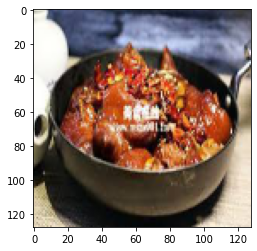

In [71]:
plt.imshow(train_data[5].permute(1,2,0)/255.)

In [56]:
# Use 1648 images as training set and 413 images as test set
train_indice = np.random.choice(2061, 1648, replace=False)
train_path = images[train_indice]
train_label = labels[train_indice]
test_path = images[~train_indice]
test_label = labels[~train_indice]

In [57]:
train_loader = create_data_loader(train_path, train_label, 64)
test_loader = create_data_loader(test_path, test_label, 64)

In [58]:
criterion = nn.CrossEntropyLoss()

In [ ]:
train_model(net = net, n_epoch = 10, my_lr = 1e-5, train_loader = train_loader, test_loader = test_loader, verbose=1)

In [59]:
my_lenet = LeNet5_convnet()

In [61]:
train_model(net = net, n_epoch = 10, my_lr = 1e-4, train_loader = train_loader, test_loader = test_loader, verbose=1)

epoch= 1 	 time= 0.25045070648193357 min 	 lr= 0.0001 	 loss= 2.571212731874906 	 error= 93.46955120563507 percent
error rate on test set = 93.50961538461539 percent

epoch= 2 	 time= 0.7579139947891236 min 	 lr= 0.0001 	 loss= 2.570761506374066 	 error= 93.44951923076923 percent
error rate on test set = 93.48958340974954 percent

epoch= 3 	 time= 1.2799691319465638 min 	 lr= 0.0001 	 loss= 2.5703920217660756 	 error= 93.50961538461539 percent
error rate on test set = 93.50961538461539 percent

epoch= 4 	 time= 1.7911593755086264 min 	 lr= 0.0001 	 loss= 2.5702823308797984 	 error= 93.46955120563507 percent
error rate on test set = 93.46955120563507 percent



KeyboardInterrupt: 

In [95]:
device = torch.device("cpu")